# NBA All-Star Prediction

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data Source #1

In [139]:
df_2021 = pd.read_excel("C:/Users/14699/nba-allstar-prediction/2020-2021.xlsx", index_col=0)

Here we are exploring the dataset, looking at the available features and getting a sense of what data lies within the dataframe

In [140]:
df_2021.head()

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards
Rk,,,,,,,,,,,,,,,,,,,,,
1,Stephen Curry,32,GSW,PG,63,63,34.2,10.4,21.7,0.482,...,0.5,5.0,5.5,5.8,1.2,0.1,3.4,1.9,32.0,"MVP-3,AS,NBA1"
2,Bradley Beal,27,WAS,SG,60,60,35.8,11.2,23.0,0.485,...,1.2,3.5,4.7,4.4,1.2,0.4,3.1,2.3,31.3,"AS,NBA3"
3,Damian Lillard,30,POR,PG,67,67,35.8,9.0,19.9,0.451,...,0.5,3.7,4.2,7.5,0.9,0.3,3.0,1.5,28.8,"MVP-7,AS,NBA2"
4,Joel Embiid,26,PHI,C,51,51,31.1,9.0,17.6,0.513,...,2.2,8.4,10.6,2.8,1.0,1.4,3.1,2.4,28.5,"MVP-2,DPOY-7,AS,NBA2"
5,Giannis Antetokounmpo,26,MIL,PF,61,61,33.0,10.3,18.0,0.569,...,1.6,9.4,11.0,5.9,1.2,1.2,3.4,2.8,28.1,"MVP-4,DPOY-5,AS,NBA1"


In [141]:
df_2021.columns

Index(['Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Awards'],
      dtype='object')

Here we are creating our target feature, All-Star selection. Since the original dataset had all awards listed within a single column, we can create a binary column for All-Star selection.

In [142]:
df_2021['AllStar'] = df_2021['Awards'].apply(lambda x: 1 if 'AS' in str(x) else 0)

Here we are verifying that the changes have been applied correctly.

In [143]:
df_2021.tail()

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards,AllStar
Rk,,,,,,,,,,,,,,,,,,,,,
381,Gabe Vincent,24,MIA,PG,50,7,13.1,1.8,4.7,0.378,...,0.9,1.1,1.3,0.4,0.0,0.7,1.6,4.8,NaN,0
382,Damian Jones,25,3TM,C,39,10,14.0,1.8,2.6,0.680,...,2.2,3.1,0.7,0.3,0.7,0.7,2.0,4.7,NaN,0
382,Damian Jones,25,PHO,C,14,0,6.7,0.6,1.1,0.500,...,0.8,1.3,0.3,0.1,0.4,0.4,1.4,1.6,NaN,0
382,Damian Jones,25,LAL,C,8,6,14.0,2.0,2.1,0.941,...,2.3,3.3,0.1,0.1,0.9,0.6,2.8,5.4,NaN,0
382,Damian Jones,25,SAC,C,17,4,20.1,2.7,4.1,0.657,...,3.3,4.5,1.4,0.5,1.0,0.9,2.1,6.9,NaN,0


In [144]:
df_2021.shape

(500, 31)

Here we are starting to clean the dataset by dropping unimportant features.

In [145]:
df_2021 = df_2021.drop(columns=['Age','ORB','DRB','FGA','3PA','2PA','FTA','Pos','PF'])

In [146]:
df_2021.columns

Index(['Player', 'Team', 'G', 'GS', 'MP', 'FG', 'FG%', '3P', '3P%', '2P',
       '2P%', 'eFG%', 'FT', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS',
       'Awards', 'AllStar'],
      dtype='object')

Now we have gotten rid of features that can't affect All-Star selection:

* age
* number of offensive and defensive rebounds (feature containing number of total rebounds remains in the dataset)
* number of attempted 3-point field goals, 2-point field goals, and free throws
* position
* number of fouls

Now we are going to clean the target features up a little bit. There are multiple rows for many players due to them changing teams as a result of a trade. We must give each player only one row.

In [147]:
# Identifying players with multiple entries
multiple_team_entries_2021 = df_2021[df_2021['Team'].str.contains('TM')]

# Grabbing list of players who have aggregated rows (Team name is listed as 2TM or 3TM)
players_with_multiple_teams_2021 = multiple_team_entries_2021['Player'].unique()

# Keep only the aggregated rows
df_2021_cleaned = df_2021[(df_2021['Player'].isin(players_with_multiple_teams_2021)) & 
                          (df_2021['Team'].str.contains('TM'))]

# Include players with single entries
single_team_players_2021 = df_2021[~df_2021['Player'].isin(players_with_multiple_teams_2021)]

# Combine our dataframes
df_2021 = pd.concat([df_2021_cleaned, single_team_players_2021], ignore_index=True)

In order to determine which features affect All-Star selection, we can create some visualizations.

In [148]:
df_2021 = df_2021.drop(columns='Awards')

In [149]:
df_2021.columns

Index(['Player', 'Team', 'G', 'GS', 'MP', 'FG', 'FG%', '3P', '3P%', '2P',
       '2P%', 'eFG%', 'FT', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS',
       'AllStar'],
      dtype='object')

In [150]:
corr_2021 = df_2021[['G', 'GS', 'MP', 'FG', 'FG%', '3P', '3P%', '2P','2P%', 'eFG%', 'FT', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS','AllStar']].corr()

<Axes: >

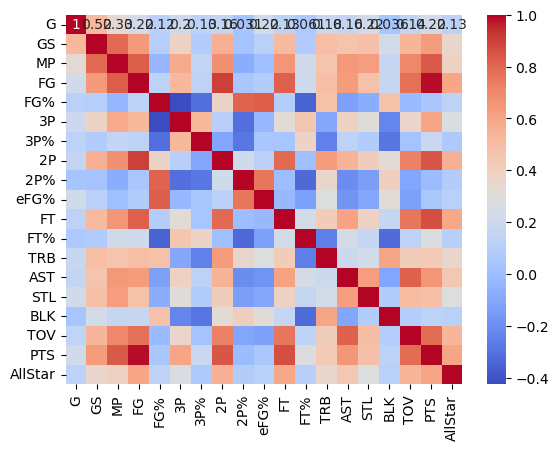

In [151]:
sns.heatmap(corr_2021, annot=True, cmap='coolwarm')

Based on the heatmap, we can see that All-Star selection is correlated with points, turnovers, assists, free throws, 2-point field goals, and total field goals. Given the context of how All-Star selections are truly made, these features are definitely going to be used to train the model.

Now we are going to use basketball context to determine whether there is any visual evidence for including some important player performance features, such as rebounds, blocks, 3-point field goals, efficient field goal percentage, and steals.

<Axes: xlabel='AllStar', ylabel='TRB'>

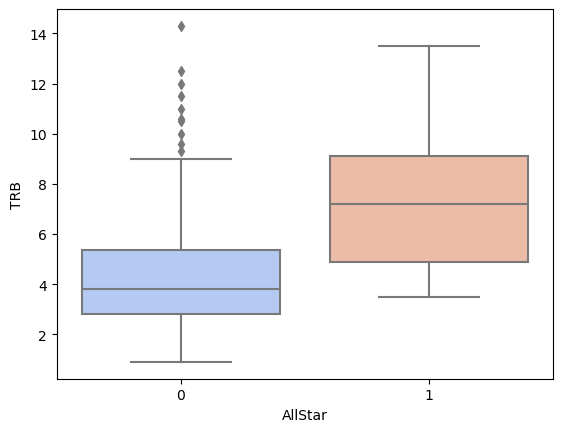

In [152]:
sns.boxplot(data=df_2021, x='AllStar', y='TRB', palette='coolwarm')

Here we can see that total rebounds could potentially have some impact on determining All-Star selection.

<Axes: xlabel='AllStar', ylabel='BLK'>

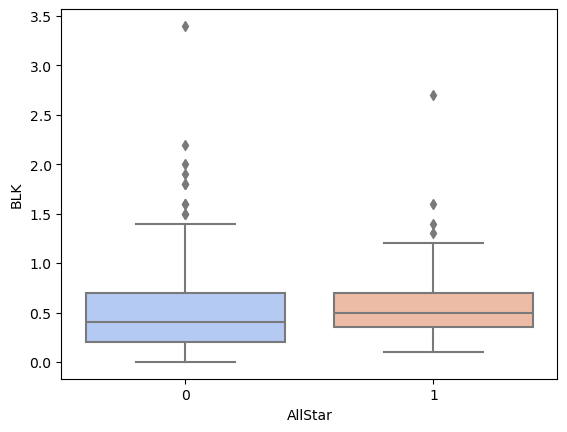

In [153]:
sns.boxplot(data=df_2021, x='AllStar', y='BLK', palette='coolwarm')

Here we can see that blocks are clearly not an important feature in determining All-Star selection.

<Axes: xlabel='AllStar', ylabel='3P'>

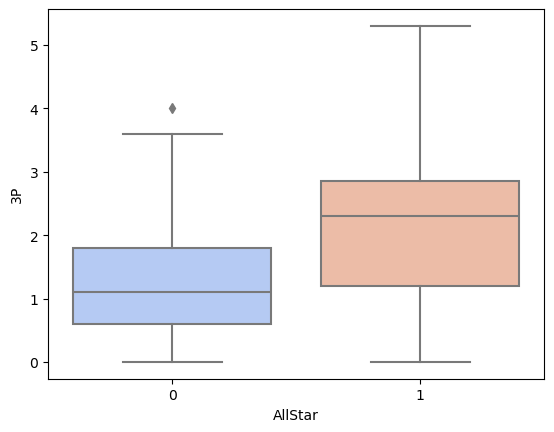

In [154]:
sns.boxplot(data=df_2021, x='AllStar', y='3P', palette='coolwarm')

<Axes: xlabel='AllStar', ylabel='eFG%'>

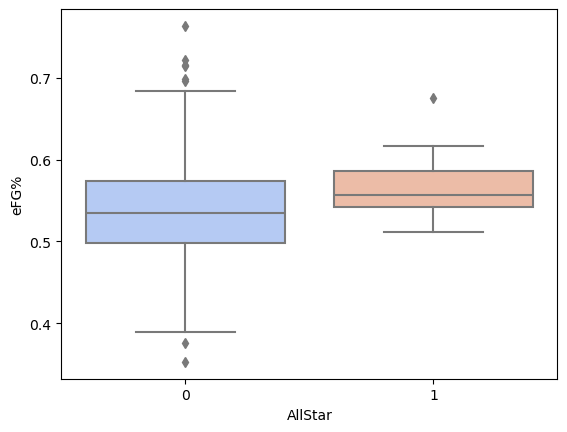

In [155]:
sns.boxplot(data=df_2021, x='AllStar', y='eFG%', palette='coolwarm')

Here we can see that neither 3-point field goals nor efficient field goal percentage are important features in determining All-Star selection.

<Axes: xlabel='AllStar', ylabel='STL'>

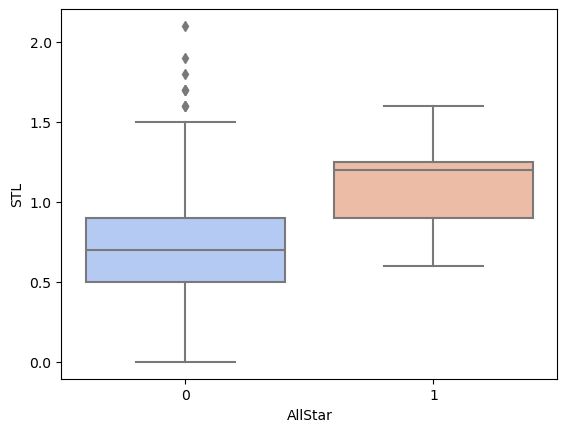

In [156]:
sns.boxplot(data=df_2021, x='AllStar', y='STL', palette='coolwarm')

Here we can see that steals might have some impact on determining All-Star selection.

Now we are separating our selected target features from the rest of the dataset.

In [157]:
target_features_2021 = df_2021[['Player','PTS','AST','TRB','STL','TOV','FT','2P','FG','AllStar']]

In [158]:
target_features_2021.head()

,Player,PTS,AST,TRB,STL,TOV,FT,2P,FG,AllStar
0,James Harden,24.6,10.8,7.9,1.2,4.0,6.3,5.0,7.8,1
1,Nikola Vučević,23.4,3.8,11.7,0.9,1.8,1.9,7.0,9.5,1
2,Caris LeVert,20.2,5.2,4.6,1.4,2.2,3.1,5.9,7.6,0
3,Victor Oladipo,19.8,4.6,4.8,1.4,2.5,3.2,4.8,7.1,0
4,Norman Powell,18.6,1.9,3.1,1.2,1.7,3.4,3.9,6.3,0


Now we have aggregated player data for all 381 NBA players during the 2020-2021 season. We must repeat the same data wrangling steps for the 2021-2022 and 2022-2023 seasons.

### Data Source #2

In [159]:
df_2022 = pd.read_excel("C:/Users/14699/nba-allstar-prediction/2021-2022.xlsx", index_col=0)

In [160]:
df_2022.head()

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards
Rk,,,,,,,,,,,,,,,,,,,,,
1,Joel Embiid,27,PHI,C,68,68,33.8,9.8,19.6,0.499,...,2.1,9.6,11.7,4.2,1.1,1.5,3.1,2.7,30.6,"MVP-2,AS,NBA2"
2,LeBron James,37,LAL,C,56,56,37.2,11.4,21.8,0.524,...,1.1,7.1,8.2,6.2,1.3,1.1,3.5,2.2,30.3,"MVP-10,AS,NBA3"
3,Giannis Antetokounmpo,27,MIL,PF,67,67,32.9,10.3,18.6,0.553,...,2.0,9.6,11.6,5.8,1.1,1.4,3.3,3.2,29.9,"MVP-3,DPOY-6,AS,NBA1"
4,Kevin Durant,33,BRK,PF,55,55,37.2,10.5,20.3,0.518,...,0.5,6.9,7.4,6.4,0.9,0.9,3.5,2.1,29.9,"MVP-10,AS,NBA2"
5,Luka Dončić,22,DAL,PG,65,65,35.4,9.9,21.6,0.457,...,0.9,8.3,9.1,8.7,1.2,0.6,4.5,2.2,28.4,"MVP-5,AS,NBA1"


In [161]:
df_2022['AllStar'] = df_2022['Awards'].apply(lambda x: 1 if 'AS' in str(x) else 0)

In [162]:
df_2022 = df_2022.drop(columns=['Age','ORB','DRB','FGA','3PA','2PA','FTA','Pos','PF','Awards'])

In [163]:
# Identifying players with multiple entries
multiple_team_entries_2022 = df_2022[df_2022['Team'].str.contains('TM')]

# Grabbing list of players who have aggregated rows (Team name is listed as 2TM or 3TM)
players_with_multiple_teams_2022 = multiple_team_entries_2022['Player'].unique()

# Keep only the aggregated rows
df_2022_cleaned = df_2022[(df_2022['Player'].isin(players_with_multiple_teams_2022)) & 
                          (df_2022['Team'].str.contains('TM'))]

# Include players with single entries
single_team_players_2022 = df_2022[~df_2022['Player'].isin(players_with_multiple_teams_2022)]

# Combine our dataframes
df_2022 = pd.concat([df_2022_cleaned, single_team_players_2022], ignore_index=True)

In [164]:
corr_2022 = df_2022[['G', 'GS', 'MP', 'FG', 'FG%', '3P', '3P%', '2P','2P%', 'eFG%', 'FT', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS','AllStar']].corr()

<Axes: >

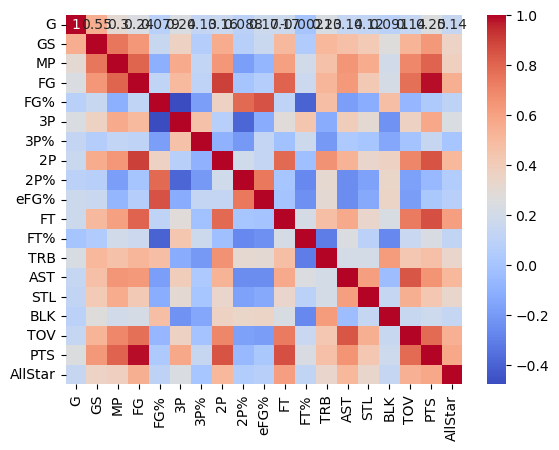

In [165]:
sns.heatmap(corr_2022, annot=True, cmap='coolwarm')

Here we can see that Assists have a higher correlation with All-Star selection compared to the previous year, so it is good we chose it as a feature earlier.

In [166]:
target_features_2022 = df_2022[['Player','PTS','AST','TRB','STL','TOV','FT','2P','FG','AllStar']]

In [167]:
target_features_2022.head()

,Player,PTS,AST,TRB,STL,TOV,FT,2P,FG,AllStar
0,CJ McCollum,22.1,5.1,4.3,1.1,2.0,1.9,5.7,8.6,0
1,James Harden,22.0,10.3,7.7,1.3,4.4,7.2,4.0,6.3,1
2,Kristaps Porziņģis,20.2,2.3,8.1,0.7,1.6,4.9,5.4,6.9,0
3,Norman Powell,19.0,2.1,3.2,0.9,1.5,4.2,3.8,6.2,0
4,Domantas Sabonis,18.9,5.2,12.1,1.0,3.1,4.0,6.5,7.1,0


### Data Source #3

In [168]:
df_2023 = pd.read_excel("C:/Users/14699/nba-allstar-prediction/2022-2023.xlsx", index_col=0)

In [169]:
df_2023.head()

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards
Rk,,,,,,,,,,,,,,,,,,,,,
1,Joel Embiid,28,PHI,C,66,66,34.6,11.0,20.1,0.548,...,1.7,8.4,10.2,4.2,1.0,1.7,3.4,3.1,33.1,"MVP-1,DPOY-9,CPOY-5,AS,NBA1"
2,Luka Dončić,23,DAL,PG,66,66,36.2,10.9,22.0,0.496,...,0.8,7.8,8.6,8.0,1.4,0.5,3.6,2.5,32.4,"MVP-8,CPOY-8,AS,NBA1"
3,Damian Lillard,32,POR,PG,58,58,36.3,9.6,20.7,0.463,...,0.8,4.0,4.8,7.3,0.9,0.3,3.3,1.9,32.2,"CPOY-10,AS,NBA3"
4,Shai Gilgeous-Alexander,24,OKC,PG,68,68,35.5,10.4,20.3,0.510,...,0.9,4.0,4.8,5.5,1.6,1.0,2.8,2.8,31.4,"MVP-5,CPOY-7,AS,NBA1"
5,Giannis Antetokounmpo,28,MIL,PF,63,63,32.1,11.2,20.3,0.553,...,2.2,9.6,11.8,5.7,0.8,0.8,3.9,3.1,31.1,"MVP-3,DPOY-6,AS,NBA1"


In [170]:
df_2023['AllStar'] = df_2023['Awards'].apply(lambda x: 1 if 'AS' in str(x) else 0)

In [171]:
df_2023 = df_2023.drop(columns=['Age','ORB','DRB','FGA','3PA','2PA','FTA','Pos','PF','Awards'])

In [172]:
# Identifying players with multiple entries
multiple_team_entries_2023 = df_2023[df_2023['Team'].str.contains('TM')]

# Grabbing list of players who have aggregated rows (Team name is listed as 2TM or 3TM)
players_with_multiple_teams_2023 = multiple_team_entries_2023['Player'].unique()

# Keep only the aggregated rows
df_2023_cleaned = df_2023[(df_2023['Player'].isin(players_with_multiple_teams_2023)) & 
                          (df_2023['Team'].str.contains('TM'))]

# Include players with single entries
single_team_players_2023 = df_2023[~df_2023['Player'].isin(players_with_multiple_teams_2023)]

# Combine our dataframes
df_2023 = pd.concat([df_2023_cleaned, single_team_players_2023], ignore_index=True)

In [173]:
corr_2023 = df_2023[['G', 'GS', 'MP', 'FG', 'FG%', '3P', '3P%', '2P','2P%', 'eFG%', 'FT', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS','AllStar']].corr()

<Axes: >

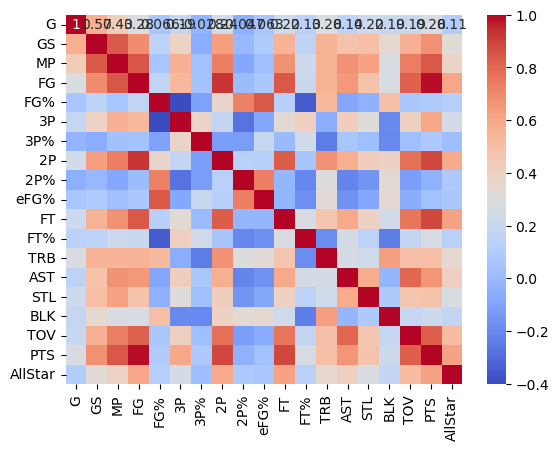

In [174]:
sns.heatmap(corr_2023, annot=True, cmap='coolwarm')

In [175]:
target_features_2023 = df_2023[['Player','PTS','AST','TRB','STL','TOV','FT','2P','FG','AllStar']]

In [176]:
target_features_2023.head()

,Player,PTS,AST,TRB,STL,TOV,FT,2P,FG,AllStar
0,Kevin Durant,29.1,5.0,6.7,0.7,3.3,6.5,8.3,10.3,1
1,Kyrie Irving,27.1,5.5,5.1,1.1,2.1,4.1,6.8,9.9,1
2,Mikal Bridges,20.1,3.3,4.4,1.1,1.5,3.8,5.1,7.1,0
3,D'Angelo Russell,17.8,6.2,3.0,1.0,2.6,2.5,3.5,6.3,0
4,Spencer Dinwiddie,17.3,6.5,3.4,0.8,1.8,3.4,3.5,5.8,0
